## Teste Técnico - Programa Trainee triggo.ai 2025

This project is divided in 4 parts and each part have it's own particular questions:
- Data cleaning and modelling.
    - Importing the dataset .csv file from Kaggle ("olistbr/brazilian-ecommerce")
    - Data cleaning and normalizing
    - Creation of a relational data modelling
    - Describing each step in the data prep
- Exploratory analysis using SQL and Python
    - Orders volume per month and its seasonality
    - The distribution of orders delivery time
    - The relationship between delivery costs and delivery distance
    - Which are the best-selling products in revenue
    - Brazilian states with the highest average order value
- Solving Business Problems
    - Retention analysis of recurring customers (one or more orders in the analysis period) and which insights could we extract
    - Late delivery prediction analysis:
        - Define what a late delivery is.
        - Use relevant fields to create the features for the model
        - Divide train and test datasets
        - Implement the prediction analisys using Random Forest Classifier
        - Evaluate the model performance and explain the results
    - Customer Segmentation: 
        - Segment the customers in groups
        - Do a behavior analysis  of each group and suggest marketing strategies for each one.
    - Customer Satisfaction: 
        - Explore the relationship between customer review score and other aspects, like product category, delivery time, average order price.
        - Identify the factors that impact the most
- Visualization and Dashboarding
    - MoM Barchart of Orders filtered by Brazil States and Product Category
    - Heatmap of Orders by Region/Brazil States
    - Multiple graphs show the relationship between customer satisfaction and delivery time
    - A dashboard comparing different vendors with best performance in sales, customer satisfaction and delivery time

### Other packages used in this notebook

In [3]:
# %pip install kagglehub
# %pip install geopy
# %pip install duckdb

### Imports

In [28]:
import numpy as np
import pandas as pd
import duckdb
import kagglehub

import matplotlib.pyplot as plt
import seaborn as sns

from geopy import distance 

### Kaggle dataset download

In [5]:
# Download latest version
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Lucas\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2


### Reading the datasets into Pandas DataFrames

Listing all the 9 datasets and describing them:

- olist_customers_dataset.csv
    - Contains information about the customers
    - Raw column names: customer_id, customer_unique_id, customer_zip_code_prefix, customer_city and customer_state
- olist_geolocation_dataset.csv
    - Contains geolocalization information of every geolocation in the dataset
    - Raw column names: geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state
- olist_order_items_dataset.csv
    - Contains information about the customers
    - Raw column names: order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value
- olist_order_payments_dataset.csv
    - Contains information the orders payments
    - Raw column names: order_id, payment_sequential, payment_type, payment_installments, payment_value
- olist_order_reviews_dataset.csv
    - Contains information about the reviews from customers for every order
    - Raw column names: review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timest
- olist_orders_dataset.csv
    - Contains information about orders details
    - Raw column names: order_id,customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date,order_estimated_delivery_date
- olist_products_dataset
    - Contains information about products details
    - Raw column names: product_id, product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
- olist_sellers_dataset
    - Contains information about the sellers
    - Raw column names: seller_id, seller_zip_code_prefix, seller_city, seller_state
- product_category_name_translation
    - Contains name translations, wont be used in this project

![Table Diagram](<Table Diagram.png>)

### Read the olist_customers_dataset.csv into df_customers


In [6]:
dtype = {'customer_zip_code_prefix': 'string'}

df_customers = pd.read_csv(path + "\olist_customers_dataset.csv", dtype=dtype)

df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,08775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


### Read the olist_geolocation_dataset.csv into df_geolocation


In [7]:
dtype = {'geolocation_zip_code_prefix': 'string'}

df_geolocation = pd.read_csv(path + "\olist_geolocation_dataset.csv", dtype=dtype)

df_geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,01037,-23.545621,-46.639292,sao paulo,SP
1,01046,-23.546081,-46.644820,sao paulo,SP
2,01046,-23.546129,-46.642951,sao paulo,SP
3,01041,-23.544392,-46.639499,sao paulo,SP
4,01035,-23.541578,-46.641607,sao paulo,SP


### Read the olist_order_items_dataset.csv into df_order_items


In [8]:
parse_dates = ['shipping_limit_date']

df_order_items = pd.read_csv(path + "\olist_order_items_dataset.csv", parse_dates=parse_dates)

df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


### Read the olist_order_payments_dataset.csv to df_order_payments


In [9]:
df_order_payments = pd.read_csv(path + "\olist_order_payments_dataset.csv")

df_order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


### Read the olist_order_reviews_dataset.csv to df_order_reviews


In [10]:
parse_dates = ['review_creation_date', 'review_answer_timestamp']

df_order_reviews = pd.read_csv(path + "\olist_order_reviews_dataset.csv", parse_dates=parse_dates)

df_order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


### Read the olist_orders_dataset.csv to df_orders


In [11]:
parse_dates = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

df_orders = pd.read_csv(path + "\olist_orders_dataset.csv", parse_dates=parse_dates)

df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


### Read the olist_products_dataset.csv to df_products


In [12]:
df_products = pd.read_csv(path + "\olist_products_dataset.csv")

df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


### Read the olist_sellers_dataset.csv to df_sellers


In [13]:
dtype = {'seller_zip_code_prefix': 'string'}

df_sellers = pd.read_csv(path + "\olist_sellers_dataset.csv", dtype=dtype)

df_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,04195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


### Orders volume per month and its seasonality

Here I used datetrunc to get the months of every date, then format with strftime, to get only a Month date. If datepart was used it would return an Integer instead of a String, so I prefer this way.

In [14]:
orders_per_month = duckdb.query(
                                    "SELECT \
                                        strftime(datetrunc('month', order_purchase_timestamp), '%m') AS month, \
                                        COUNT( order_id) AS count_orders \
                                    FROM df_orders \
                                    GROUP BY month \
                                    ORDER BY month"

                                ).df()

orders_per_month

,month,count_orders
0,01,8069
1,02,8508
2,03,9893
3,04,9343
4,05,10573
5,06,9412
6,07,10318
7,08,10843
8,09,4305
9,10,4959


### Months of August, May and July were the top 3 orders per months

Im using iloc to get the first and second columns

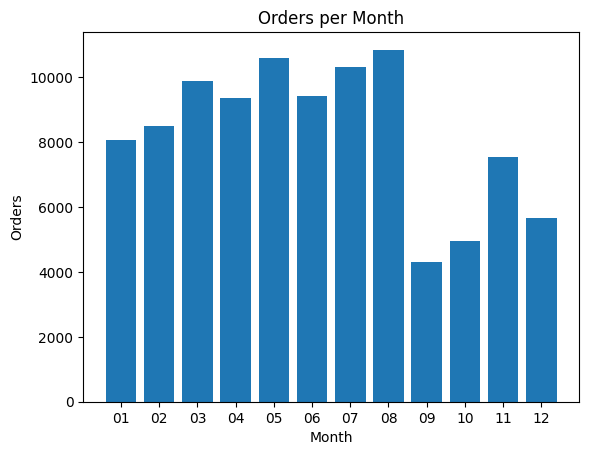

In [15]:
month = orders_per_month.iloc[:, 0]
count_orders = orders_per_month.iloc[:, 1]

plt.bar(month, count_orders)
plt.title('Orders per Month')
plt.xlabel('Month')
plt.ylabel('Orders')
plt.show()


### The Distribution of orders delivery time

To calculate the delivery time, Im using the order_delivered_customer_date as delivery time and the order_approved_at when the timer to the order be shipped

Calculating the mode of the dataset, to get the most frequent day to delivery

Selection only orders with the order_status = delivered

In [16]:
order_delivery_time = duckdb.query(
                                    "SELECT\
                                        order_id, \
                                        datediff('day', order_approved_at, order_delivered_customer_date) AS day_to_delivery \
                                    FROM df_orders \
                                    WHERE order_status = 'delivered'"

                                ).df()

print('Mode: ', order_delivery_time.day_to_delivery.mode())

Mode:  0    7
Name: day_to_delivery, dtype: Int64


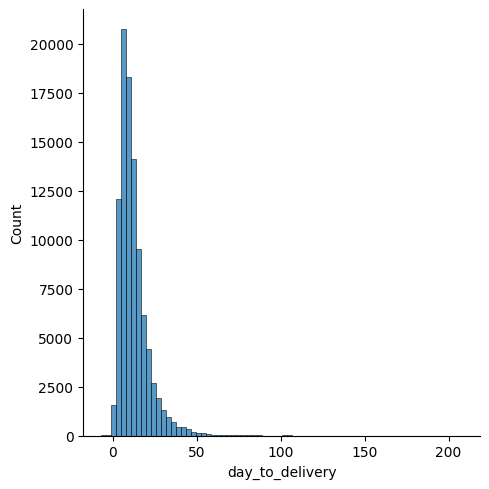

In [17]:
sns.displot(order_delivery_time, x="day_to_delivery", binwidth=3)

### SQL JOINs to get the right data from the multiple tables

- Starting with Customer table joining Geolocation table, to get the latitute and longitude from each customer
- As latitude and Longitude coulh have multiple values for each zip code, I decided to use the AVG function to get an average of each location
- Then joining Customer table with Orders table to get the order_id

In [18]:
customer_geo = duckdb.query(
"""
  SELECT
    c.customer_id,
    c.customer_zip_code_prefix,
    c.customer_city,
    c.customer_state,
    o.order_id,
    o.order_approved_at,
    o.order_delivered_customer_date,
    o.order_estimated_delivery_date,
    AVG(g.geolocation_lat) AS customer_lat,
    AVG(g.geolocation_lng) AS customer_lng
  FROM
    df_customers AS c
  INNER JOIN
    df_geolocation AS g
      ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix
      AND c.customer_city = g.geolocation_city
      AND c.customer_state = g.geolocation_state
  INNER JOIN 
    df_orders AS o
      ON c.customer_id = o.customer_id
      AND order_status = 'delivered'
  GROUP BY
    1,2,3,4,5,6,7,8
"""
).df()

customer_geo.head()

,customer_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,customer_lat,customer_lng
0,9d797a1a7d8ddb192708608d25197161,57303,arapiraca,AL,00d94e8901b75ee0d6ef1f87f947b666,2017-05-01 14:25:13,2017-05-23 05:55:05,2017-06-05,-9.780293,-36.638107
1,41dd55a5cc1d3ee4e4cd29c5049078ac,58033,joao pessoa,PB,72306b6ce07a9860eab715afd663dd73,2018-04-01 15:08:30,2018-04-30 14:58:36,2018-05-07,-7.114708,-34.839821
2,ba33a4cae101690de645fad078ba96f3,58076,joao pessoa,PB,9db5b1ba7f04533533e400a1f2589d66,2018-02-02 00:52:12,2018-02-14 23:15:21,2018-03-07,-7.175363,-34.880290
3,f0c3d576e70e1eb0ae245c9483b5ad95,57920,sao luis do quitunde,AL,5c9a7e0865669dc34b4e6a062751d8f4,2018-03-09 21:28:26,2018-04-26 12:11:33,2018-04-11,-9.314832,-35.566200
4,738ebe48e12040500665dd143aa28cdc,57975,colonia leopoldina,AL,adf684f287283640cb375a2e8ada8c82,2017-01-31 23:30:12,2017-02-16 11:49:01,2017-03-09,-8.918538,-35.729345


Joining the customer_geo table with df_order_items, to get some metrics and to join with df_products, to get products metrics, for usage in the freight calculation 

In [46]:

order_products = duckdb.query(
"""
  SELECT
    cg.customer_id,
    cg.customer_zip_code_prefix,
    cg.customer_city,
    cg.customer_state,
    cg.customer_lat,
    cg.customer_lng,
    cg.order_id,
    cg.order_approved_at,
    cg.order_delivered_customer_date,
    cg.order_estimated_delivery_date, 
    oi.seller_id,
    oi.product_id,
    oi.freight_value,
    p.product_category_name,
    p.product_height_cm,
    p.product_length_cm,
    p.product_width_cm,
    p.product_weight_g
  FROM 
    customer_geo AS cg
  INNER JOIN   
    df_order_items AS oi
      ON cg.order_id = oi.order_id
  INNER JOIN   
    df_products AS p
      ON oi.product_id = p.product_id
"""
).df()

order_products

,customer_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,order_id,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,seller_id,product_id,freight_value,product_category_name,product_height_cm,product_length_cm,product_width_cm,product_weight_g
0,9b5d68f669f7ed215f789471556529fe,22431,rio de janeiro,RJ,-22.982844,-43.224740,e8805f1923e711c407c454831b49643f,2017-04-06 02:42:41,2017-04-19 15:58:17,2017-05-02,0afccdb8a34ee5c79f7c06faf2b4d56e,80103e141ed0da3b1d63cb0c7d1f7d48,14.87,telefonia,17.0,17.0,17.0,150.0
1,5ca0847591cdad1a279fd89aa4e58e04,22230,rio de janeiro,RJ,-22.937298,-43.176890,e880a2a0f19dcb0f2ef51fed71ef34c9,2018-03-29 01:28:02,2018-04-24 19:17:22,2018-05-04,d1c281d3ae149232351cd8c8cc885f0d,37116a322ceabbe82c30430000af0db3,19.32,cama_mesa_banho,10.0,20.0,15.0,200.0
2,5ca0847591cdad1a279fd89aa4e58e04,22230,rio de janeiro,RJ,-22.937298,-43.176890,e880a2a0f19dcb0f2ef51fed71ef34c9,2018-03-29 01:28:02,2018-04-24 19:17:22,2018-05-04,d1c281d3ae149232351cd8c8cc885f0d,37116a322ceabbe82c30430000af0db3,19.32,cama_mesa_banho,10.0,20.0,15.0,200.0
3,7c5df4a2ffa11a657198a578c83fd58f,20520,rio de janeiro,RJ,-22.926259,-43.231846,e880c960b083af6aae64e809acf0693c,2017-07-14 00:23:56,2017-07-28 21:07:30,2017-08-09,4869f7a5dfa277a7dca6462dcf3b52b2,461f43be3bdf8844e65b62d9ac2c7a5a,15.86,relogios_presentes,14.0,20.0,16.0,444.0
4,7c5df4a2ffa11a657198a578c83fd58f,20520,rio de janeiro,RJ,-22.926259,-43.231846,e880c960b083af6aae64e809acf0693c,2017-07-14 00:23:56,2017-07-28 21:07:30,2017-08-09,4869f7a5dfa277a7dca6462dcf3b52b2,461f43be3bdf8844e65b62d9ac2c7a5a,15.86,relogios_presentes,14.0,20.0,16.0,444.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109860,da5edefc151065bf935b9bf2c412e96b,27263,volta redonda,RJ,-22.524805,-44.117692,e87d63870bcff2f72abfc64454bfff05,2017-08-09 13:44:08,2017-08-18 15:49:50,2017-08-31,638cba8be1fb599bbb76fd6948351eb3,10f2fea49b203930a1f4c0a3a892d960,11.85,alimentos_bebidas,21.0,33.0,27.0,400.0
109861,e530863105eede13aab60014aa569bd7,27213,volta redonda,RJ,-22.506040,-44.089839,e87da23aab323df28deb2e98d41a3fb0,2018-04-24 20:33:39,2018-05-04 18:58:42,2018-05-23,b8bc237ba3788b23da09c0f1f3a3288c,4aa6014eceb682077f9dc4bffebc05b0,21.09,utilidades_domesticas,15.0,89.0,40.0,10150.0
109862,81112d3c8ff7d1dc7b26c0f2052012ab,80240,curitiba,PR,-25.448991,-49.288610,e87eab6d3c69146b0c36c905a34600e7,2018-01-07 00:06:40,2018-01-15 12:47:02,2018-02-05,bba74270a87732727b5a3b4fd9ac1c39,59391e840980a4bb6df5f44d3d734df7,15.79,esporte_lazer,4.0,16.0,13.0,600.0
109863,412557c43340a382c45cb5729dde3e98,14600,sao joaquim da barra,SP,-20.586056,-47.863892,e87eae32b47767da815139559a6ec52e,2018-03-27 11:27:43,2018-04-06 21:12:26,2018-04-13,4d6d651bd7684af3fffabd5f08d12e5a,1a405418406359cc2b8815f93bf359c2,20.25,esporte_lazer,20.0,20.0,20.0,4550.0


- Joining the seller_df and the geolocation_df to get the seller localization
- Again, using the AVG function to get an average of each zip_code

In [20]:

seller_geo = duckdb.query(
"""
  SELECT
    s.seller_id,
    s.seller_zip_code_prefix,
    s.seller_city,
    s.seller_state,
    AVG(g.geolocation_lat) AS seller_lat,
    AVG(g.geolocation_lng) AS seller_lng
  FROM
    df_sellers AS s
  INNER JOIN
    df_geolocation AS g
      ON s.seller_zip_code_prefix = g.geolocation_zip_code_prefix
      AND s.seller_city = g.geolocation_city
      AND s.seller_state = g.geolocation_state
  GROUP BY
    1,2,3,4
"""
).df()

seller_geo.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng
0,2addf05f476d0637864454e93ba673d5,70856,brasilia,DF,-15.761213,-47.879109
1,2493dc3f20131696a0ecdb9948051a8d,71065,brasilia,DF,-15.842738,-47.976091
2,44073f8b7e41514de3b7815dd0237f4f,71070,brasilia,DF,-15.836052,-47.951014
3,39f776d2974049026ff531fc42ef2a3e,74835,goiania,GO,-16.715789,-49.274217
4,01bcc9d254a0143f0ce9791b960b2a47,76400,uruacu,GO,-14.518915,-49.142360


- Joining the order_products with the seller_geo df to get the sellers data
- Joining order_products with the df_order_reviews, and get the review score
- Use the coalesce function to give a 0 to the review_score in case it was NULL (the customer didnt review)

In [45]:
master_table = duckdb.query(
"""
  SELECT
    op.order_id,
    coalesce(r.review_score,0) AS review_score,
    order_approved_at,
    order_delivered_customer_date,
    order_estimated_delivery_date, 

    product_id,
    freight_value,
    product_category_name,
    product_height_cm,
    product_length_cm,
    product_width_cm,
    product_weight_g, 

    customer_id,
    customer_zip_code_prefix,
    customer_city,
    customer_state,
    customer_lat,
    customer_lng,

    s.seller_id,
    s.seller_zip_code_prefix,
    s.seller_city,
    s.seller_state,
    seller_lat,
    seller_lng
  FROM
    order_products AS op
  INNER JOIN
    seller_geo AS s
      ON op.seller_id = s.seller_id
  LEFT JOIN
    df_order_reviews AS r
      ON op.order_id = r.order_id
"""
).df()

master_table

,order_id,review_score,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,product_id,freight_value,product_category_name,product_height_cm,product_length_cm,...,customer_city,customer_state,customer_lat,customer_lng,seller_id,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng
0,d6dae36830ffe3962efff0e91cc64127,3,2017-12-14 12:18:29,2018-01-03 16:40:33,2018-01-18,e9def91e99c8ecb7c5cef5e31506a056,16.25,brinquedos,11.0,19.0,...,maurilandia,GO,-17.978762,-50.340128,850f4f8af5ea87287ac68de36e29107f,04367,sao paulo,SP,-23.651498,-46.667168
1,d6db7f667096b9209c177893ddedb788,4,2017-11-29 21:17:10,2017-12-07 21:46:49,2017-12-15,97b3b8e8ed22d0ceb3b3c520e806a334,7.78,eletronicos,14.0,22.0,...,hortolandia,SP,-22.854438,-47.212780,8b321bb669392f5163d04c59e235e066,01212,sao paulo,SP,-23.538663,-46.639925
2,d6dde74bdeb424af6b660214881b4845,4,2017-07-26 17:35:21,2017-08-07 20:32:34,2017-08-21,548e5bfe28edceab6b51fa707cc9556f,27.84,cama_mesa_banho,2.0,44.0,...,ponta pora,MS,-22.533178,-55.724120,da8622b14eb17ae2831f4ac5b9dab84a,13405,piracicaba,SP,-22.708702,-47.664701
3,d6df2c35f7b163ef2a7bc19fa0151314,4,2018-02-24 14:28:01,2018-02-28 23:35:19,2018-03-12,c6c4ba8c85c4f5ffa22b732272a0e99d,10.96,esporte_lazer,13.0,17.0,...,sao paulo,SP,-23.596623,-46.600283,7bac63f6603d382cc8d0832eb6c100a8,05713,sao paulo,SP,-23.626403,-46.730381
4,d6df3e183721aa30b30577e1184eaa7f,5,2018-07-07 17:30:14,2018-07-11 14:42:25,2018-07-19,431772d0bf9d5e9a46fc78cb834a28ee,7.88,relogios_presentes,2.0,16.0,...,piracicaba,SP,-22.729029,-47.641148,6560211a19b47992c3666cc44a7e94c0,05849,sao paulo,SP,-23.652314,-46.755690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107488,d6717d9840d700bd7be08d9ca8bb791b,0,2017-11-02 02:15:53,2017-11-08 17:48:59,2017-11-21,7d40b684cc830baa8f7760f6fb1528c0,10.94,moveis_escritorio,11.0,53.0,...,sao paulo,SP,-23.545921,-46.643994,8c16d1f32a54d92897cc437244442e1b,89023,blumenau,SC,-26.949943,-49.076925
107489,d6717d9840d700bd7be08d9ca8bb791b,0,2017-11-02 02:15:53,2017-11-08 17:48:59,2017-11-21,7d40b684cc830baa8f7760f6fb1528c0,10.94,moveis_escritorio,11.0,53.0,...,sao paulo,SP,-23.545921,-46.643994,8c16d1f32a54d92897cc437244442e1b,89023,blumenau,SC,-26.949943,-49.076925
107490,d5b96096b282a551c36fc1d4a9bb2f75,0,2018-05-01 03:32:37,2018-05-15 15:28:57,2018-05-25,21af4f32f6f1cab0bb13d7563dc06e70,18.23,construcao_ferramentas_iluminacao,19.0,16.0,...,ararangua,SC,-28.945781,-49.483212,d6b1ce66b035a475f00c017792ff9769,13327,salto,SP,-23.179531,-47.313384
107491,d5b96096b282a551c36fc1d4a9bb2f75,0,2018-05-01 03:32:37,2018-05-15 15:28:57,2018-05-25,21af4f32f6f1cab0bb13d7563dc06e70,18.23,construcao_ferramentas_iluminacao,19.0,16.0,...,ararangua,SC,-28.945781,-49.483212,d6b1ce66b035a475f00c017792ff9769,13327,salto,SP,-23.179531,-47.313384


In [ ]:
delivery_costs = duckdb.query(
"""
  SELECT
    order_id,

    product_id,
    freight_value,

    #calcule of the cubic weight
    (product_height_cm * product_length_cm * product_width_cm)/6000 AS product_volume_cm,
    product_weight_g,

    customer_id,
    customer_zip_code_prefix,
    customer_lat,
    customer_lng,

    seller_id,
    seller_zip_code_prefix,
    seller_lat,
    seller_lng
  FROM
    master_table 
"""
).df()

delivery_costs

,order_id,product_id,freight_value,product_volume_cm,product_weight_g,customer_id,customer_zip_code_prefix,customer_lat,customer_lng,seller_id,seller_zip_code_prefix,seller_lat,seller_lng
0,d6dae36830ffe3962efff0e91cc64127,e9def91e99c8ecb7c5cef5e31506a056,16.25,4180.0,500.0,3528b0f4fc89cd237f14b2ef3fa1530d,75930,-17.978762,-50.340128,850f4f8af5ea87287ac68de36e29107f,04367,-23.651498,-46.667168
1,d6db7f667096b9209c177893ddedb788,97b3b8e8ed22d0ceb3b3c520e806a334,7.78,5236.0,200.0,63469895c7367d40ce7a72e99d8347c9,13183,-22.854438,-47.212780,8b321bb669392f5163d04c59e235e066,01212,-23.538663,-46.639925
2,d6dde74bdeb424af6b660214881b4845,548e5bfe28edceab6b51fa707cc9556f,27.84,3080.0,1200.0,137da6b7c6f269c569e4377b37b84242,79904,-22.533178,-55.724120,da8622b14eb17ae2831f4ac5b9dab84a,13405,-22.708702,-47.664701
3,d6df2c35f7b163ef2a7bc19fa0151314,c6c4ba8c85c4f5ffa22b732272a0e99d,10.96,3315.0,321.0,3c285e92488bf716f1ffa7380ad177c3,04216,-23.596623,-46.600283,7bac63f6603d382cc8d0832eb6c100a8,05713,-23.626403,-46.730381
4,d6df3e183721aa30b30577e1184eaa7f,431772d0bf9d5e9a46fc78cb834a28ee,7.88,352.0,250.0,6e6e4321afd3581094cef66e0880a859,13419,-22.729029,-47.641148,6560211a19b47992c3666cc44a7e94c0,05849,-23.652314,-46.755690
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107488,d6717d9840d700bd7be08d9ca8bb791b,7d40b684cc830baa8f7760f6fb1528c0,10.94,18656.0,2600.0,3258445d69ee63eac4af6749b70a0305,01046,-23.545921,-46.643994,8c16d1f32a54d92897cc437244442e1b,89023,-26.949943,-49.076925
107489,d6717d9840d700bd7be08d9ca8bb791b,7d40b684cc830baa8f7760f6fb1528c0,10.94,18656.0,2600.0,3258445d69ee63eac4af6749b70a0305,01046,-23.545921,-46.643994,8c16d1f32a54d92897cc437244442e1b,89023,-26.949943,-49.076925
107490,d5b96096b282a551c36fc1d4a9bb2f75,21af4f32f6f1cab0bb13d7563dc06e70,18.23,4864.0,700.0,a8c3aa97105dafd8f641edcb5cf6a341,88905,-28.945781,-49.483212,d6b1ce66b035a475f00c017792ff9769,13327,-23.179531,-47.313384
107491,d5b96096b282a551c36fc1d4a9bb2f75,21af4f32f6f1cab0bb13d7563dc06e70,18.23,4864.0,700.0,a8c3aa97105dafd8f641edcb5cf6a341,88905,-28.945781,-49.483212,d6b1ce66b035a475f00c017792ff9769,13327,-23.179531,-47.313384


### Using the lib GeoPY its possible to calculate the distance between two point using the latitude and longitude

In [48]:
def calculate_distance(row):
    customer_location = (row['customer_lat'], row['customer_lng'])
    seller_location = (row['seller_lat'], row['seller_lng'])
    return distance.distance(customer_location, seller_location).km


delivery_costs['delivery_distance'] = delivery_costs.apply(calculate_distance, axis=1)

delivery_costs

,order_id,product_id,freight_value,product_volume_cm,product_weight_g,customer_id,customer_zip_code_prefix,customer_lat,customer_lng,seller_id,seller_zip_code_prefix,seller_lat,seller_lng,delivery_distance
0,d6dae36830ffe3962efff0e91cc64127,e9def91e99c8ecb7c5cef5e31506a056,16.25,4180.0,500.0,3528b0f4fc89cd237f14b2ef3fa1530d,75930,-17.978762,-50.340128,850f4f8af5ea87287ac68de36e29107f,04367,-23.651498,-46.667168,735.166689
1,d6db7f667096b9209c177893ddedb788,97b3b8e8ed22d0ceb3b3c520e806a334,7.78,5236.0,200.0,63469895c7367d40ce7a72e99d8347c9,13183,-22.854438,-47.212780,8b321bb669392f5163d04c59e235e066,01212,-23.538663,-46.639925,95.818305
2,d6dde74bdeb424af6b660214881b4845,548e5bfe28edceab6b51fa707cc9556f,27.84,3080.0,1200.0,137da6b7c6f269c569e4377b37b84242,79904,-22.533178,-55.724120,da8622b14eb17ae2831f4ac5b9dab84a,13405,-22.708702,-47.664701,828.687514
3,d6df2c35f7b163ef2a7bc19fa0151314,c6c4ba8c85c4f5ffa22b732272a0e99d,10.96,3315.0,321.0,3c285e92488bf716f1ffa7380ad177c3,04216,-23.596623,-46.600283,7bac63f6603d382cc8d0832eb6c100a8,05713,-23.626403,-46.730381,13.680620
4,d6df3e183721aa30b30577e1184eaa7f,431772d0bf9d5e9a46fc78cb834a28ee,7.88,352.0,250.0,6e6e4321afd3581094cef66e0880a859,13419,-22.729029,-47.641148,6560211a19b47992c3666cc44a7e94c0,05849,-23.652314,-46.755690,136.647691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107488,d6717d9840d700bd7be08d9ca8bb791b,7d40b684cc830baa8f7760f6fb1528c0,10.94,18656.0,2600.0,3258445d69ee63eac4af6749b70a0305,01046,-23.545921,-46.643994,8c16d1f32a54d92897cc437244442e1b,89023,-26.949943,-49.076925,449.713172
107489,d6717d9840d700bd7be08d9ca8bb791b,7d40b684cc830baa8f7760f6fb1528c0,10.94,18656.0,2600.0,3258445d69ee63eac4af6749b70a0305,01046,-23.545921,-46.643994,8c16d1f32a54d92897cc437244442e1b,89023,-26.949943,-49.076925,449.713172
107490,d5b96096b282a551c36fc1d4a9bb2f75,21af4f32f6f1cab0bb13d7563dc06e70,18.23,4864.0,700.0,a8c3aa97105dafd8f641edcb5cf6a341,88905,-28.945781,-49.483212,d6b1ce66b035a475f00c017792ff9769,13327,-23.179531,-47.313384,674.677464
107491,d5b96096b282a551c36fc1d4a9bb2f75,21af4f32f6f1cab0bb13d7563dc06e70,18.23,4864.0,700.0,a8c3aa97105dafd8f641edcb5cf6a341,88905,-28.945781,-49.483212,d6b1ce66b035a475f00c017792ff9769,13327,-23.179531,-47.313384,674.677464


### Calculating the relationship between freigth cost and distance